In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import sys
import time

from sklearn.preprocessing import LabelEncoder
import scipy.stats as ss

if os.name=='nt':
    try:
        mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
        os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
    except:
        pass
    
import xgboost as xgb
from sklearn.metrics import mean_squared_error 
from numba import jit

%matplotlib inline

In [2]:
def clip_rmse(preds, dtrain):
    y_test = np.array(dtrain.get_label())
    preds = np.array(preds)
    y_test = np.maximum(np.minimum(y_test, 20), 0)
    preds = np.maximum(np.minimum(preds, 20), 0)
    rmse = np.sqrt(mean_squared_error(preds,y_test))

    return 'clip-rmse', rmse

### Load data

In [3]:
train = pd.read_csv('all/sales_train.csv.gz')
test = pd.read_csv('all/test.csv.gz', index_col=0)
shop = pd.read_csv('all/shops-translated.csv')
item = pd.read_csv('all/item_category.csv')

item.drop(['item_name_translated'], axis=1, inplace=True)
shop.drop(['Name'], axis=1, inplace=True)

le = LabelEncoder()
item['item_cat1'] = le.fit_transform(item['item_cat1'].astype(str))
item['item_cat2'] = le.fit_transform(item['item_cat2'].astype(str))
shop['City'] = le.fit_transform(shop['City'])
shop['Type'] = le.fit_transform(shop['Type'])

item.set_index(['item_id'], inplace=True)
shop.set_index(['shop_id'], inplace=True)

### `x_cnt`

In [4]:
x_cnt = train.pivot_table(index=['shop_id', 'item_id'],
                      columns='date_block_num',
                      values=['item_cnt_day'], 
                      aggfunc=np.sum).fillna(0.0)

x_cnt.columns = ['m_'+str(k) 
                 for k in 
                 x_cnt.columns.get_level_values(1)]

x_cnt = test.merge(x_cnt,
                   left_on=['shop_id', 'item_id'], 
                   right_index=True, how='left').fillna(0.0)

x_cnt.set_index(['shop_id', 'item_id'], inplace=True)

In [5]:
x_cnt.head()

m_0  m_1  m_2  m_3  m_4  m_5  m_6  m_7  m_8  m_9  ...   m_24  \
shop_id item_id                                                    ...          
5       5037     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    2.0   
        5320     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
        5233     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
        5232     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
        5268     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   

                 m_25  m_26  m_27  m_28  m_29  m_30  m_31  m_32  m_33  
shop_id item_id                                                        
5       5037      0.0   0.0   0.0   1.0   1.0   1.0   3.0   1.0   0.0  
        5320      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
        5233      0.0   0.0   0.0   3.0   2.0   0.0   1.0   3.0   1.0  
        5232      0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  
        5268      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 34 columns]

### `test_dummy` only has indexes

In [6]:
test_dummy = test.copy()
test_dummy.set_index(['shop_id', 'item_id'], inplace=True)

### `x_shop_item`

In [7]:
x_shop_item = test_dummy.join(shop)

x_shop_item = x_shop_item.join(item)

### `x_sales`

In [8]:
train['sales'] = train['item_cnt_day']*train['item_price']

In [9]:
x_sales = train.pivot_table(index=['shop_id', 'item_id'],
                            columns='date_block_num',
                            values=['sales'], 
                            aggfunc=np.sum).fillna(0.0)

x_sales.columns = ['s_'+str(k) 
                   for k in 
                   x_sales.columns.get_level_values(1)]

In [10]:
x_sales.head()

s_0     s_1  s_2  s_3  s_4  s_5  s_6  s_7  s_8  s_9  ...   \
shop_id item_id                                                          ...    
0       30          0.0  8215.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    
        31          0.0  4774.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    
        32       1326.0  2210.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    
        33       1041.0  1041.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    
        35        247.0  3458.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    

                 s_24  s_25  s_26  s_27  s_28  s_29  s_30  s_31  s_32  s_33  
shop_id item_id                                                              
0       30        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
        31        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
        32        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
        33        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
        35        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 34 columns]

In [11]:
x_sales = test_dummy.join(x_sales, how='left').fillna(0.0)
x_sales.head()

s_0  s_1  s_2  s_3  s_4  s_5  s_6  s_7  s_8  s_9   ...    \
shop_id item_id                                                     ...     
5       5037     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...     
        5320     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...     
        5233     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...     
        5232     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...     
        5268     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...     

                   s_24  s_25  s_26  s_27    s_28    s_29    s_30    s_31  \
shop_id item_id                                                             
5       5037     3998.0   0.0   0.0   0.0  1299.0  1499.0  1499.0  2997.5   
        5320        0.0   0.0   0.0   0.0     0.0     0.0     0.0     0.0   
        5233        0.0   0.0   0.0   0.0  2997.0  1198.0     0.0   599.0   
        5232        0.0   0.0   0.0   0.0     0.0     0.0     0.0   599.0   
        5268        0.0   0.0   0.0   0.0     0.0     0.0     0.0     0.0   

                   s_32    s_33  
shop_id item_id                  
5       5037      749.5     0.0  
        5320        0.0     0.0  
        5233     2997.0  1199.0  
        5232        0.0     0.0  
        5268        0.0     0.0  

[5 rows x 34 columns]

### `x_cnt_diff` absolute difference between two month

In [12]:
x_cnt_diff = x_cnt.diff(axis=1).fillna(0.0)
# x_cnt_diff.drop(['m_0'], axis=1, inplace=True)

In [13]:
x_cnt_diff.head()

m_0  m_1  m_2  m_3  m_4  m_5  m_6  m_7  m_8  m_9  ...   m_24  \
shop_id item_id                                                    ...          
5       5037     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
        5320     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
        5233     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
        5232     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
        5268     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   

                 m_25  m_26  m_27  m_28  m_29  m_30  m_31  m_32  m_33  
shop_id item_id                                                        
5       5037     -2.0   0.0   0.0   1.0   0.0   0.0   2.0  -2.0  -1.0  
        5320      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
        5233      0.0   0.0   0.0   3.0  -1.0  -2.0   1.0   2.0  -2.0  
        5232      0.0   0.0   0.0   0.0   0.0   0.0   1.0  -1.0   0.0  
        5268      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 34 columns]

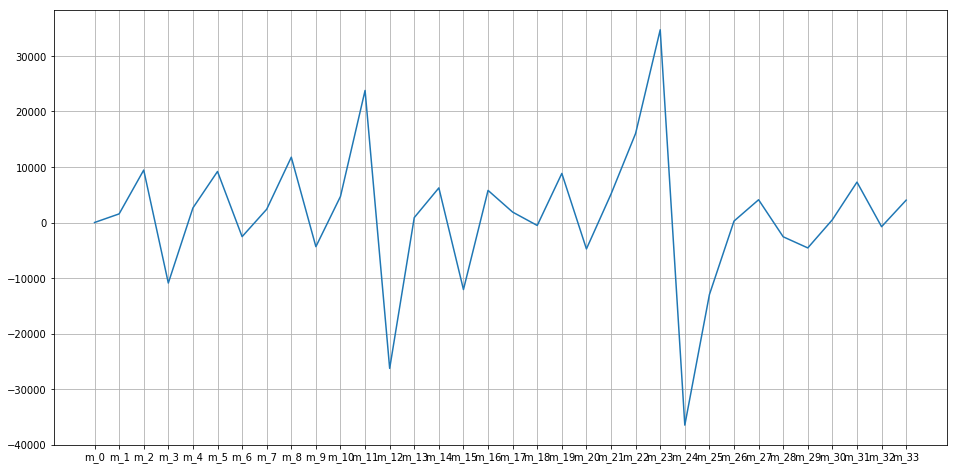

In [15]:
u = x_cnt_diff.sum(axis=0)
plt.figure(figsize=(16, 8))
plt.plot(u)
plt.grid()

### `x_cnt_m` and `x_cnt_m_diff` for `m in range(2, 13)`

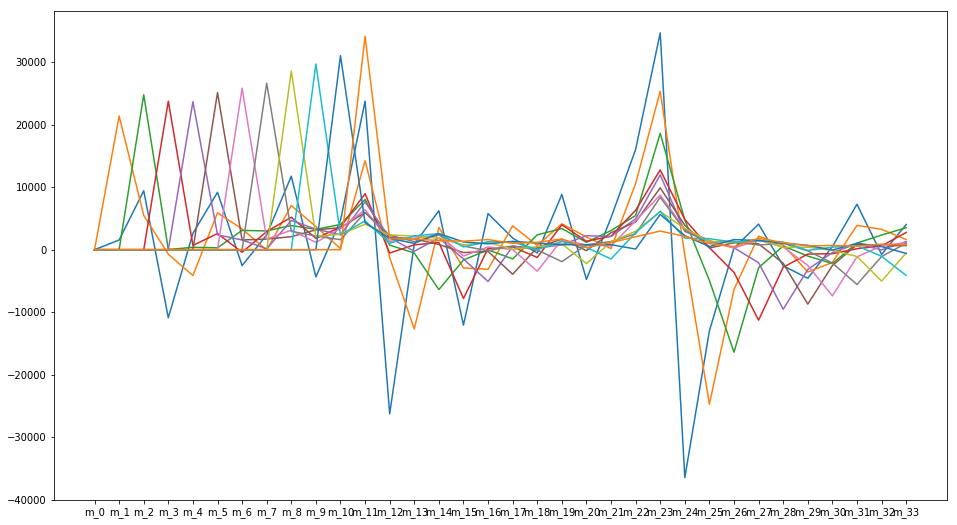

In [17]:
x_cnt_m = {}
x_cnt_m_diff = {}

plt.figure(figsize=(16, 9))
for m in range(1, 13):
    x_cnt_m[m] = x_cnt.rolling(window=m, axis=1).mean().fillna(0.0)
    x_cnt_m_diff[m] = x_cnt_m[m].diff(axis=1).fillna(0.0)
    plt.plot(x_cnt_m_diff[m].sum(axis=0))
    plt.grid()

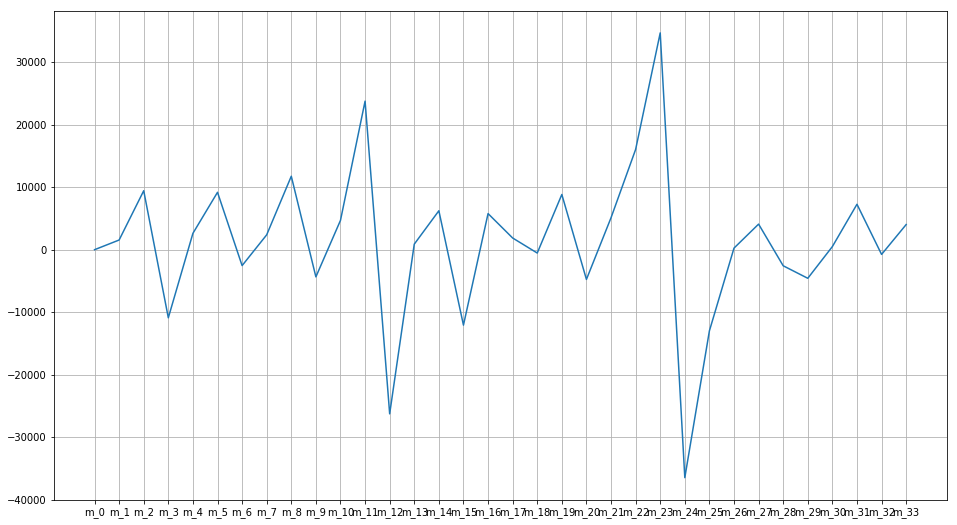

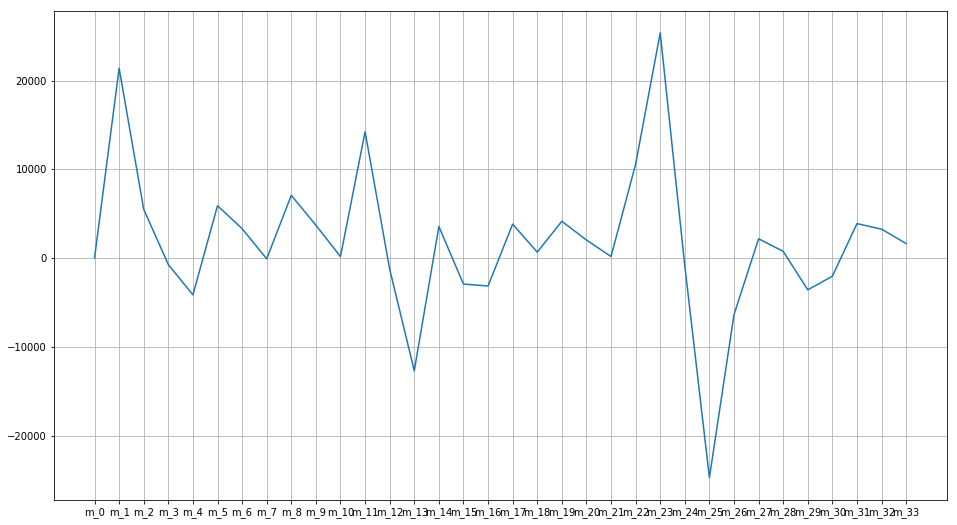

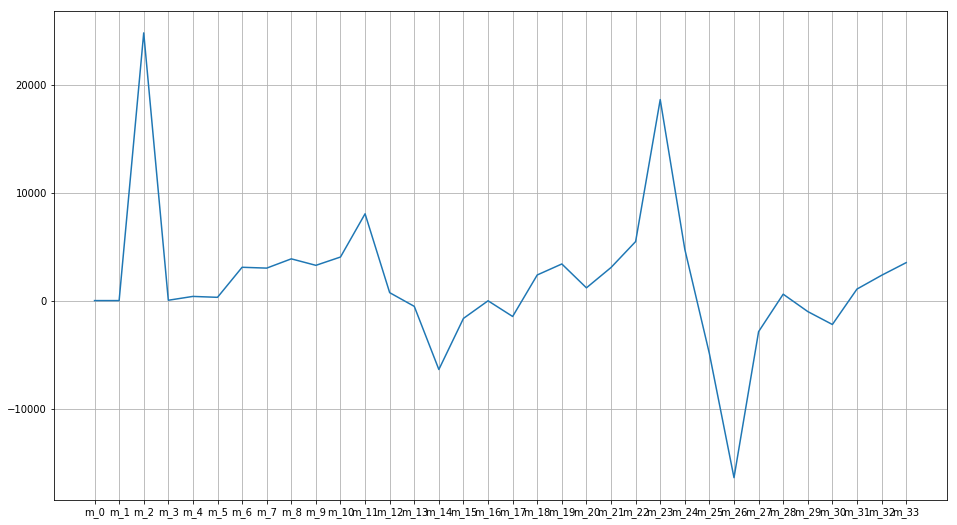

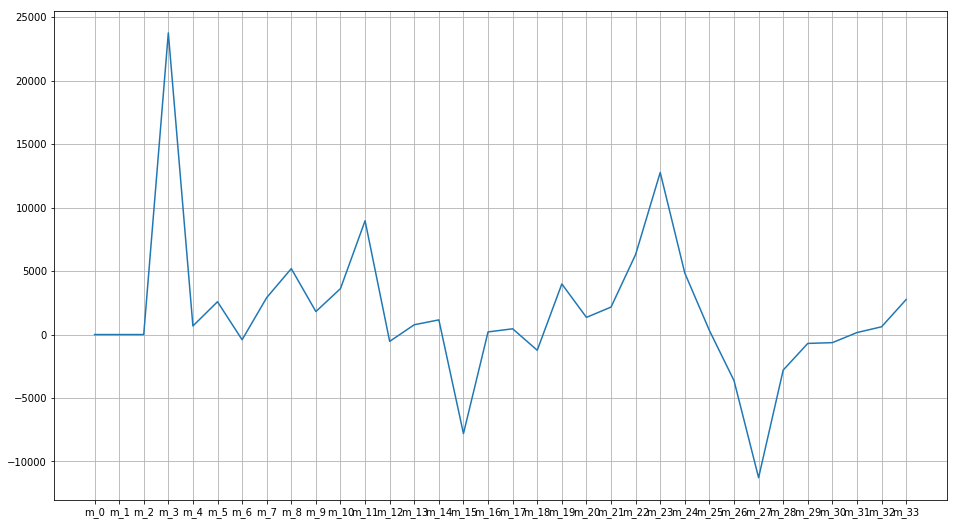

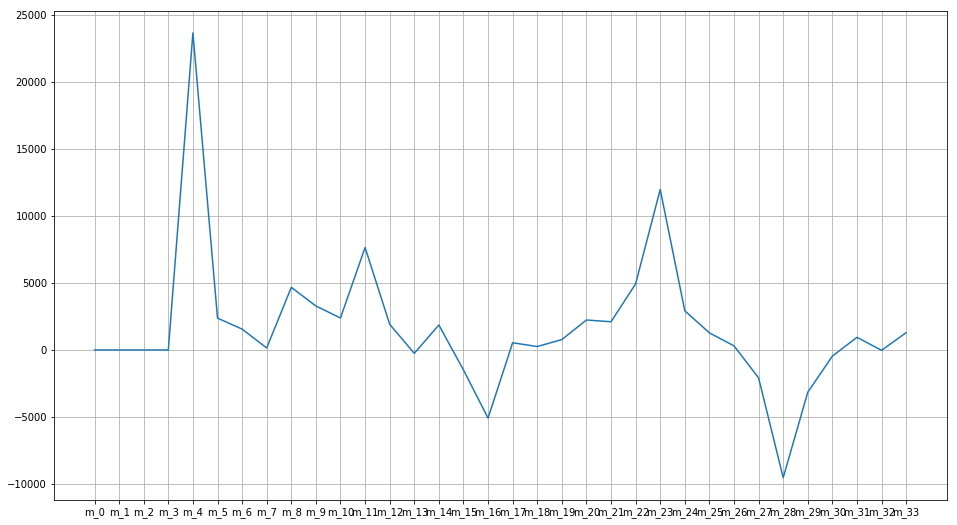

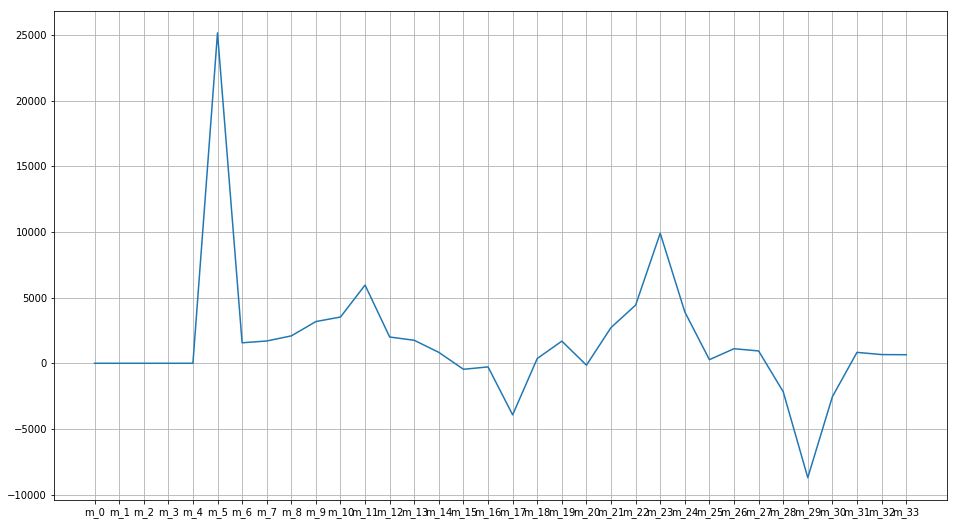

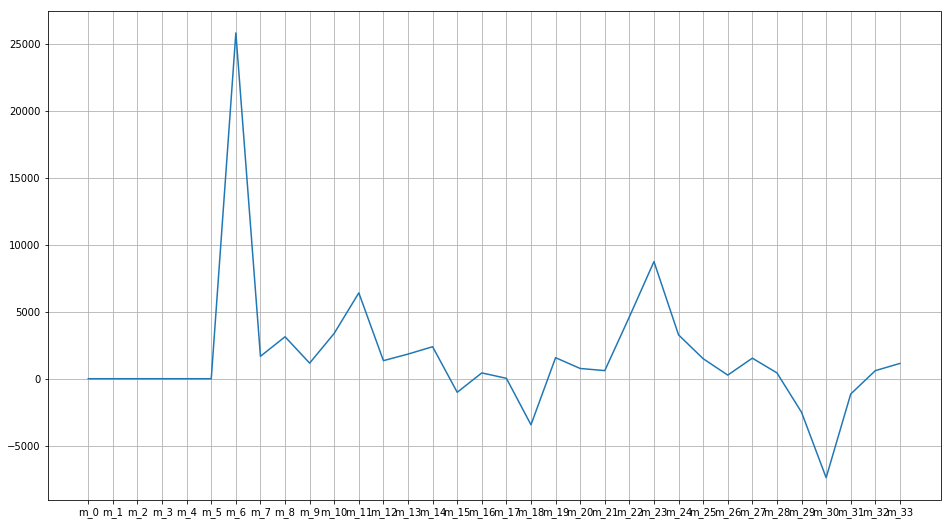

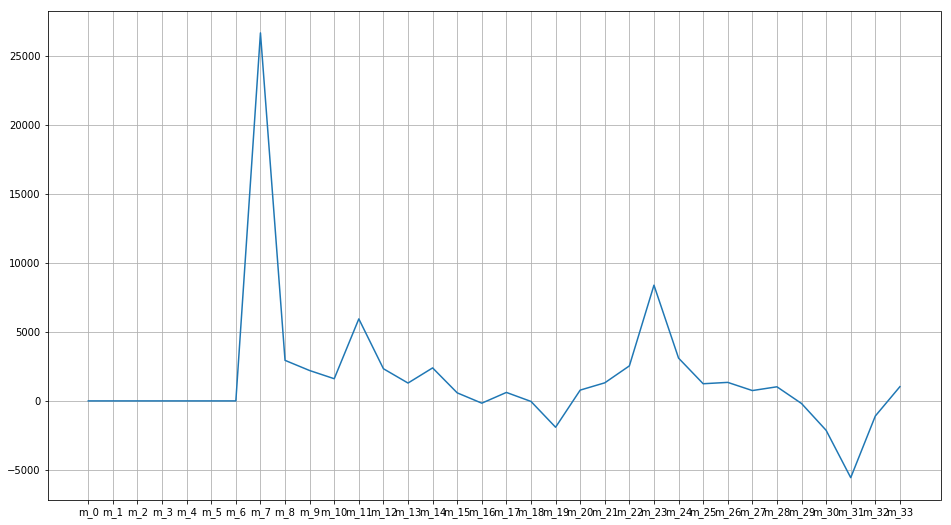

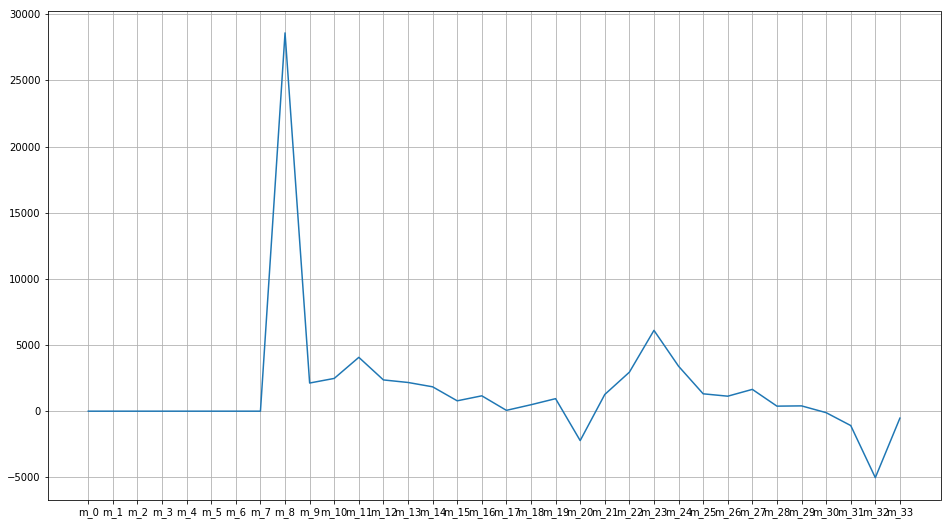

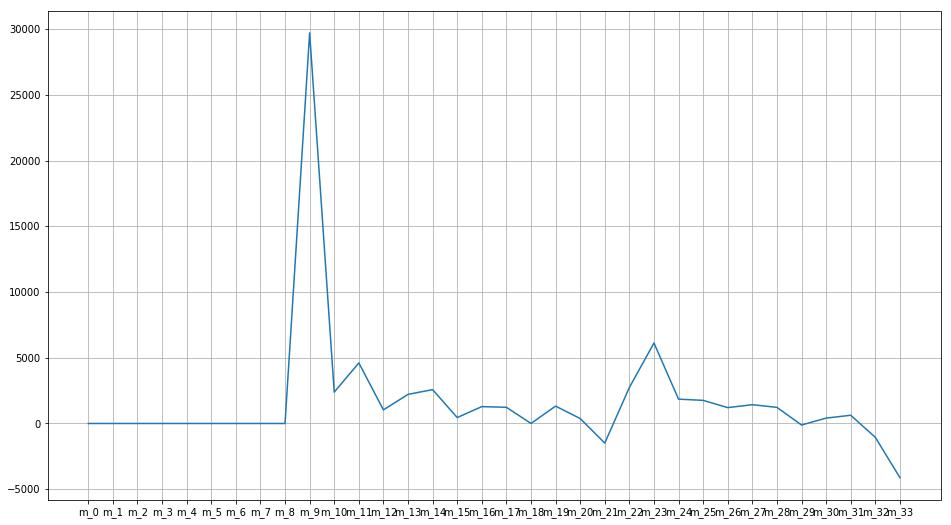

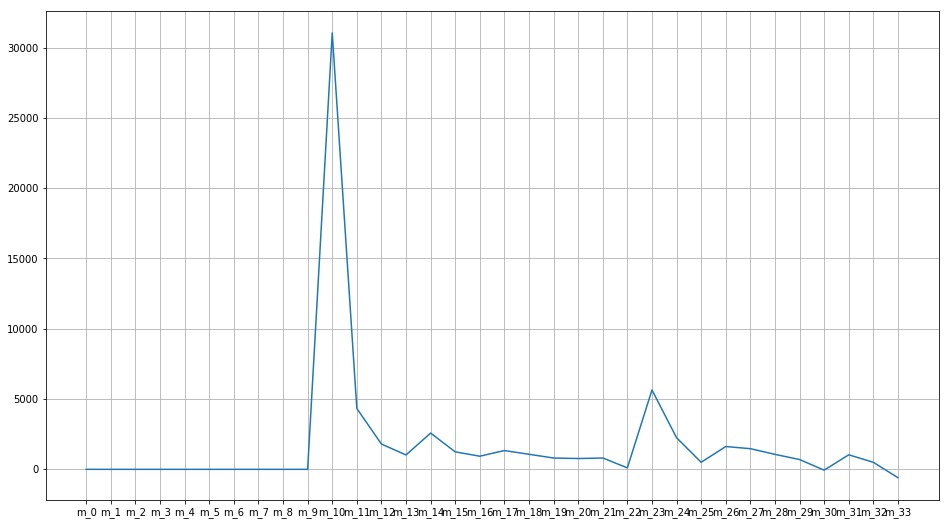

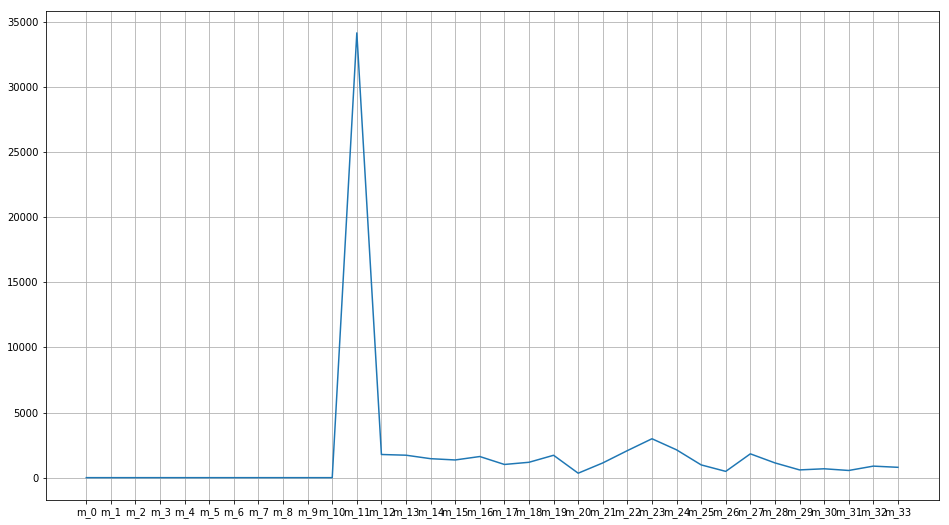

In [19]:
for m in range(1, 13):
    plt.figure(figsize=(16, 9))
    plt.plot(x_cnt_m_diff[m].sum(axis=0))
    plt.grid()

In [20]:
x_cnt_m_diff[12].shape

(214200, 34)

### `x_cnt_sum_m` and `x_cnt_sum_m_diff`

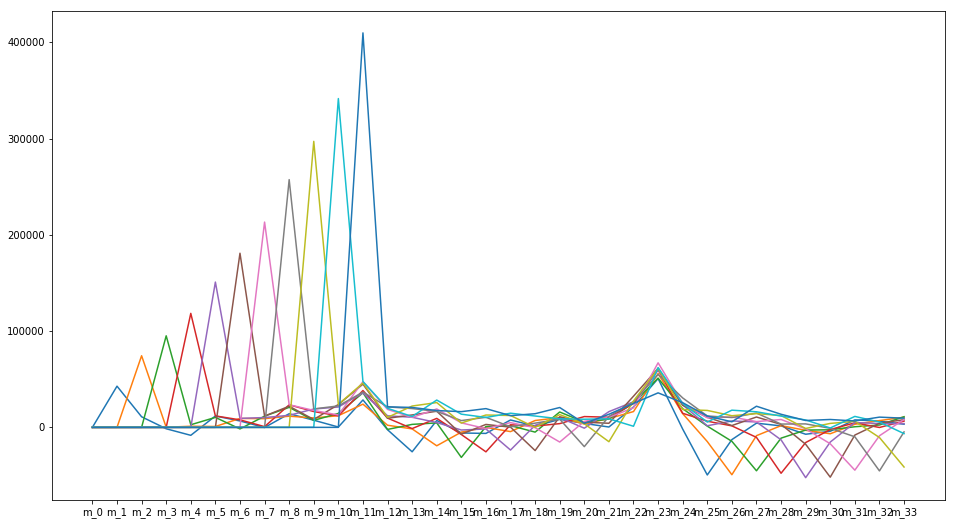

In [35]:
x_cnt_sum_m = {}
x_cnt_sum_m_diff = {}

plt.figure(figsize=(16, 9))
for m in range(2, 13):
    x_cnt_sum_m[m] = x_cnt.rolling(window=m, axis=1).sum().fillna(0.0)
    x_cnt_sum_m_diff[m] = x_cnt_sum_m[m].diff(axis=1).fillna(0.0)
    plt.plot(x_cnt_sum_m_diff[m].sum(axis=0))

### `x_sales_m` and `x_sales_m_diff` for `m in range(2, 13)`

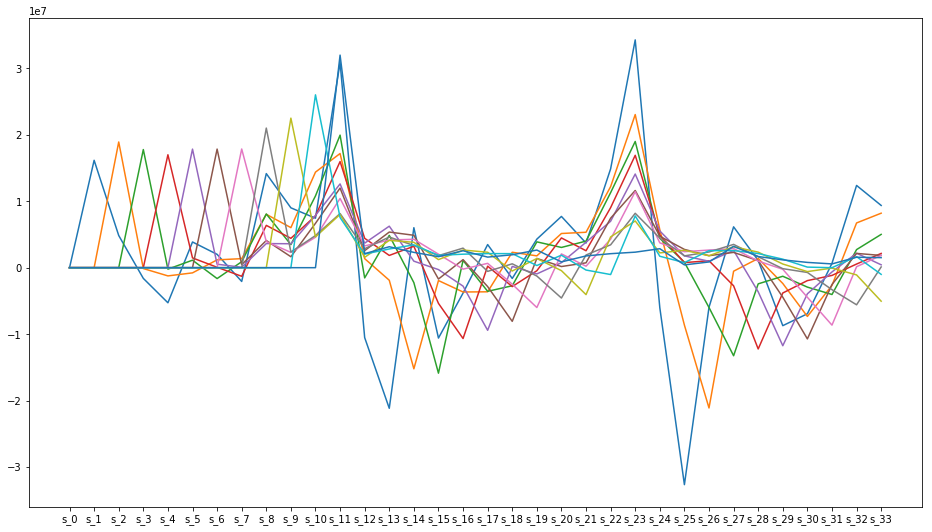

In [34]:
x_sales_m = {}
x_sales_m_diff = {}

plt.figure(figsize=(16, 9))
for m in range(2, 13):
    x_sales_m[m] = x_sales.rolling(window=m, axis=1).mean().fillna(0.0)
    x_sales_m_diff[m] = x_sales_m[m].diff(axis=1).fillna(0.0)
    plt.plot(x_sales_m_diff[m].sum(axis=0))

In [25]:
train = train.merge(item, on='item_id', how='left')

In [28]:
train = train.merge(shop, on='shop_id', how='left')

In [40]:
percentile_list = np.arange(0, 100, 5)

In [42]:
a = train.groupby('item_cat2').item_cnt_day.agg(np.percentile, 50)
b = train.groupby('item_cat2').item_cnt_day.agg(np.percentile, 25)

In [50]:
train.loc[train.item_cat2==9, 'item_cnt_day'].value_counts()

 1.0     182998
 2.0       7029
 3.0       1280
-1.0        738
 4.0        356
 5.0        151
 6.0         62
 7.0         32
 8.0          8
 9.0          4
 10.0         4
-2.0          3
 16.0         1
 57.0         1
 13.0         1
-3.0          1
 12.0         1
 14.0         1
 30.0         1
 33.0         1
 45.0         1
Name: item_cnt_day, dtype: int64

In [53]:
train.loc[train.item_cat2==0, 'item_cnt_day'].value_counts()

 1.0     11346
 2.0      1043
 3.0       231
-1.0        67
 4.0        53
 5.0        17
 6.0         6
 7.0         4
 11.0        3
 10.0        2
 8.0         2
 9.0         1
 13.0        1
-2.0         1
 16.0        1
 35.0        1
 14.0        1
Name: item_cnt_day, dtype: int64

In [ ]:
train.pivot_table()

In [54]:
a = pd.read_csv('competitive-data-science-predict-future-sales-publicleaderboard.csv')

In [57]:
a.head()

,TeamId,TeamName,SubmissionDate,Score
0,1389352,the1owl,2018-02-19 02:06:54,22.47983
1,1389352,the1owl,2018-02-19 02:23:09,2.17485
2,1389352,the1owl,2018-02-19 02:25:54,1.30724
3,1389352,the1owl,2018-02-19 02:41:51,1.18094
4,1389352,the1owl,2018-02-19 02:52:14,1.13772


In [58]:
b = a.groupby('TeamId').Score.min()

In [70]:
np.percentile(b, 33)

0.9956367999999999